### Add the scripts to the notebooks path

In [1]:
import os, sys

current_dir = os.getcwd()
print(current_dir)

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

scripts_path = os.path.join(parent_dir, 'scripts')

# Insert the path to the parent directory
sys.path.insert(0, parent_dir)

# Insert the path to the Scripts directory
sys.path.insert(0, scripts_path)

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..')))

d:\KifiyaAIM-Course\Week - 6\Bati-Bank-Credit-Scoring\notebooks


### Import Statements

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set_theme()

### Load the Data

In [4]:
PATH = "../data/data.csv"

data = pd.read_csv(PATH)

### Start of user value analysis (Credit Analysis)

In [5]:
from scripts.credit_risk_modeler import CreditScoreEngine

credit_engine = CreditScoreEngine(transaction_data=data)

1. Obtain RFMS values for each customer

In [6]:
rfms_data = credit_engine.calcualte_rfms()

2. RFMS scoring

After calculating RFMS I will score them 1 through 5,  5 being the highest and 1 being the lowest. The way I did this is by using quantiles as identifies of scores. I will create 5 quantiles and then they will 
- Recency : 5 is given to the most recent visitors and 1 is given to least recent visitors.
- Frequency: 5 is given to users that have high frequency of transactions and 1 for those who don't
- Monetary: 5 is given to users that have high transaction amount and 1 for those who have low transaction amounts.
- Std_Deviation: 5 is given to users whoes transaction amounts are consistent and 1 for those that aren't.

Now what is left is to combine the scores into one variable. Giving different importance to all of measures, i.e RFMS measures/scores. Here are the level of importance:
- Recency has the lowest importance with a weight of 10% on the overall combined score
- Monetary has the highest importance with a weight of 50% on the overall combined score
- Frequency and Std_Deviation have the same importance with both weighing 20% on the overall combined score

In [7]:
rfms_scoring = credit_engine.score_rfms(rfms_data=rfms_data)

- Investigate the distribution of the scores amongst users

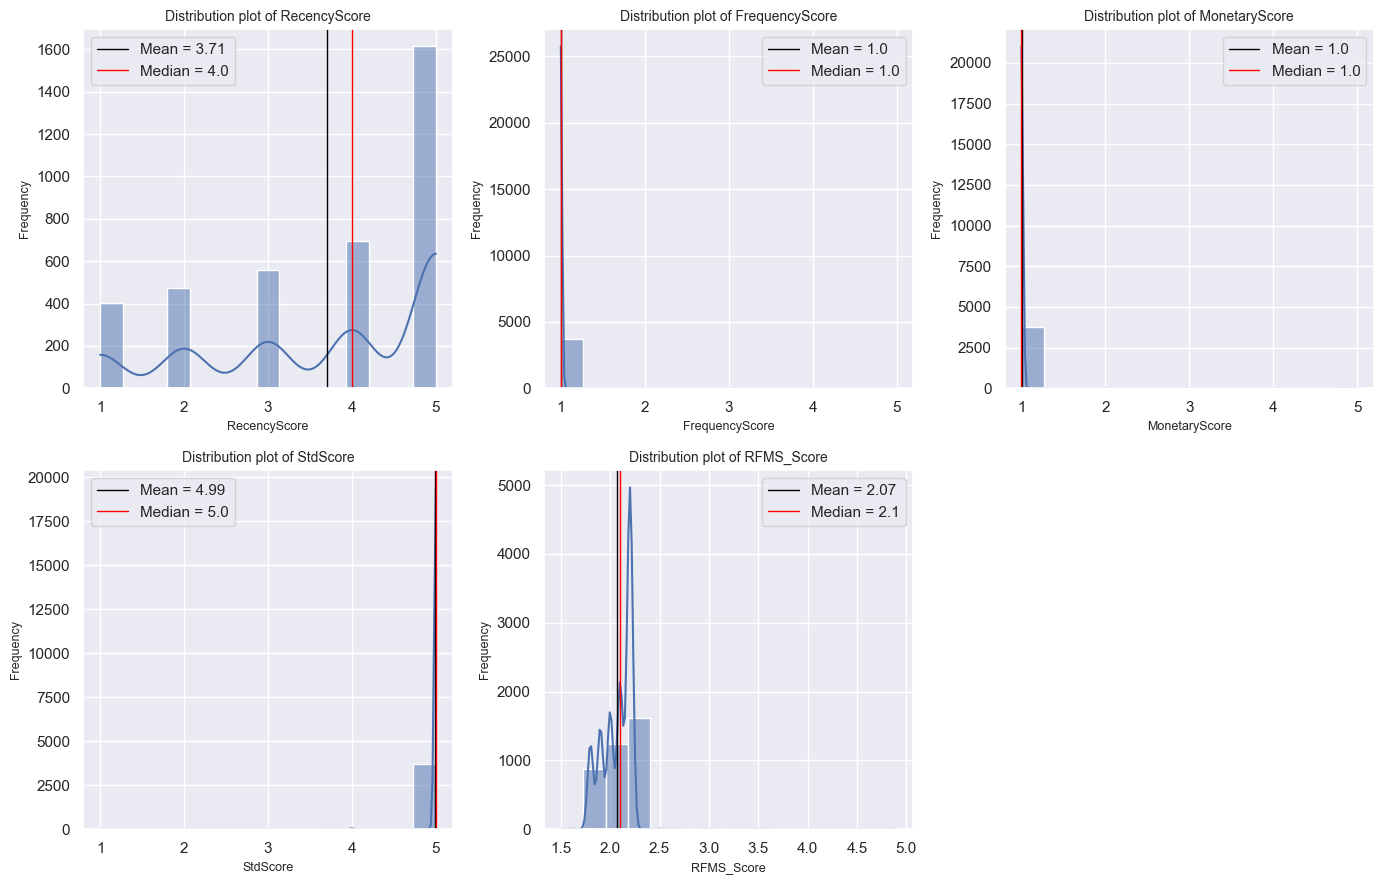

In [8]:
from scripts.utils import visualize_numerical_distribution

visualize_numerical_distribution(data=rfms_scoring)

- Add basic summary statistics to accompany the plot

In [9]:
rfms_scoring.describe()

,RecencyScore,FrequencyScore,MonetaryScore,StdScore,RFMS_Score
count,3742.000000,3742.000000,3742.000000,3742.000000,3742.000000
mean,3.707376,1.002138,1.003741,4.994655,2.071967
std,1.402501,0.080068,0.098026,0.105822,0.151998
min,1.000000,1.000000,1.000000,1.000000,1.500000
25%,3.000000,1.000000,1.000000,5.000000,2.000000
50%,4.000000,1.000000,1.000000,5.000000,2.100000
75%,5.000000,1.000000,1.000000,5.000000,2.200000
max,5.000000,5.000000,5.000000,5.000000,4.900000


From the plot and the basic summary we can observe that:
- `RecencyScore`: its distribution is left skewed. THis means that most users have high recency scores and only a few have low scores. This means that most users have performed a transaction recently. This shows good activity amongst the users.

- `FrequencyScore`: its distribution isn't skewed, but all of the results are around 1. This means that users don't perform transactions that frequently.

- `MonetaryScore`: its distribution is slightly skewed to the right, this means that most users have moved not that much money except a select few users.

- `Std_Score`: its distribution is slightly skewed to the left, this means that most users' transactions envolve somewhat the same amounts of money while few users have a habit of transfering amounts that vary a lot.

- `RFMS_Score`: its distribution is slightly skewed to the left and the scores are mostly concetrated between 1.7 - 2.4. This indicates that most users have moderate RFMS scores while there are a very small minority at the end of the score extremes.

3. Visualizing RFMS data and obtaining boundary to determine "goodness" or "badness" of users.

- Visualizing the data, x is going to be RFMS_Score while y is going to be MonetaryScore and then I used RFMS_Score for the coloring also. I didn't use Frequency because the data is almost uniform and I won't get any information out of it.

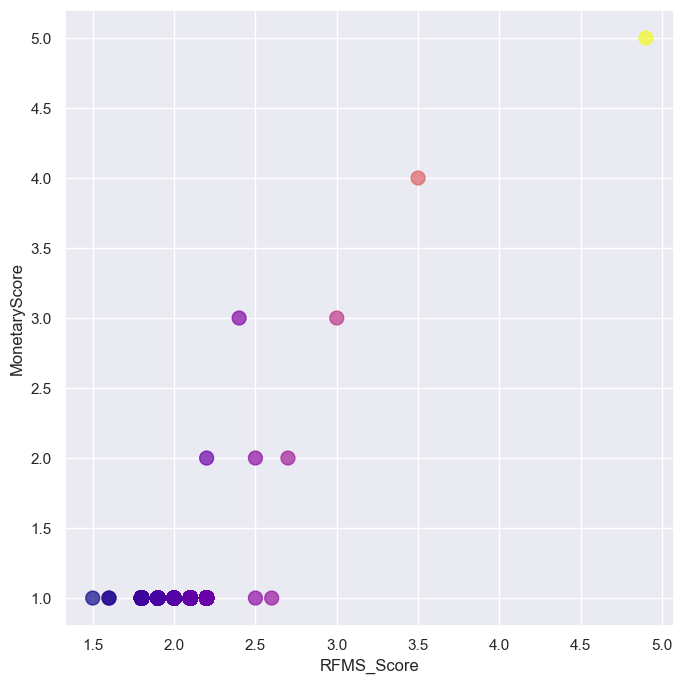

In [10]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

sc = ax.scatter(
    rfms_scoring['RFMS_Score'],   # x axis
    rfms_scoring['MonetaryScore'],  # y axis
    c=rfms_scoring['RFMS_Score'],
    cmap='plasma',            # Color map
    s=100,                    # Point size
    alpha=0.7                 # Transparency
)

# Set axis labels
ax.set_xlabel('RFMS_Score')
ax.set_ylabel('MonetaryScore')

plt.tight_layout()

- Now let me just fit a kmeans classifier and group the data into 2, then I will add the decision boundary line 

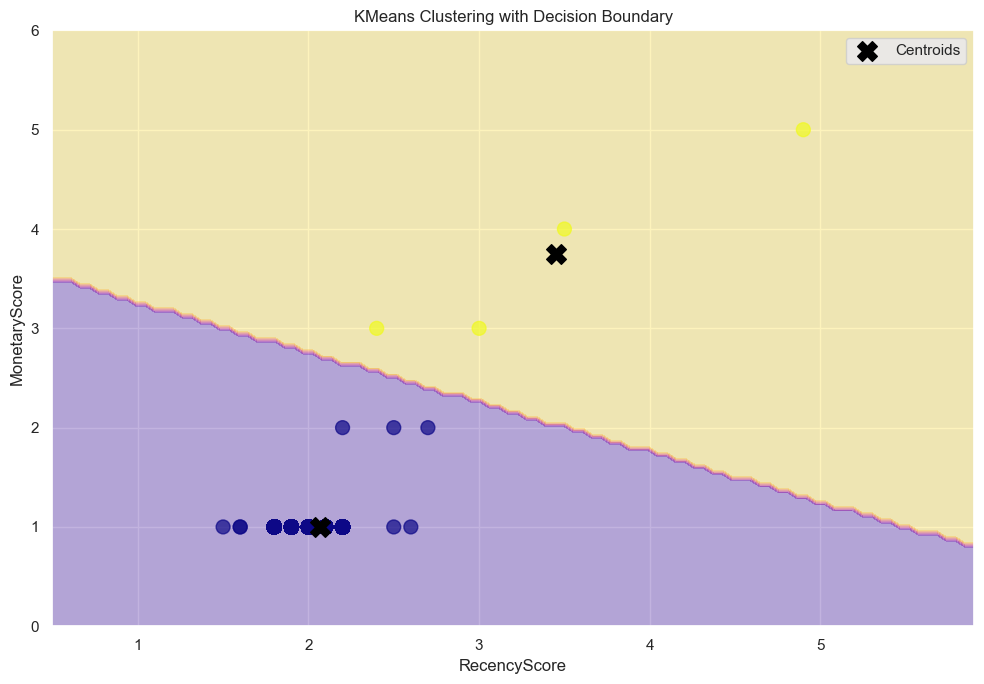

In [11]:
from sklearn.cluster import KMeans

data_for_kmeans = rfms_scoring[['RFMS_Score', 'MonetaryScore']].values

# Create KMeans object with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42, init='k-means++')

# Fit the model and predict the clusters
rfms_scoring['Cluster'] = kmeans.fit_predict(data_for_kmeans)

# Create a mesh grid for plotting the decision boundary
x_min, x_max = rfms_scoring['RFMS_Score'].min() - 1, rfms_scoring['RFMS_Score'].max() + 1
y_min, y_max = rfms_scoring['MonetaryScore'].min() - 1, rfms_scoring['MonetaryScore'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict the cluster for each point in the mesh grid
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])  # Predict clusters for the grid
Z = Z.reshape(xx.shape)  # Reshape the result to match the mesh grid shape

# Create the plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

# Fill the contours
ax.contourf(xx, yy, Z, alpha=0.3, cmap='plasma')  # Fill with color based on clusters

# Scatter plot with colors based on the cluster
sc = ax.scatter(
    rfms_scoring['RFMS_Score'],   # x axis
    rfms_scoring['MonetaryScore'],  # y axis
    c=rfms_scoring['Cluster'],       # Use the 'Cluster' column to determine the colors
    cmap='plasma',                   # Color map
    s=100,                           # Point size
    alpha=0.7                        # Transparency
)

# Set axis labels
ax.set_xlabel('RecencyScore')
ax.set_ylabel('MonetaryScore')

# Add centroids to the plot
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], color='black', s=200, marker='X', label='Centroids')

# Add a legend
plt.legend()
plt.title('KMeans Clustering with Decision Boundary')
plt.tight_layout()

# Show the plot
plt.show()

- Now let me plot the prediction of the Risk level of users and determine if this boundary is suitable or not

In [12]:
from scripts.utils import plot_bar_chart_with_values

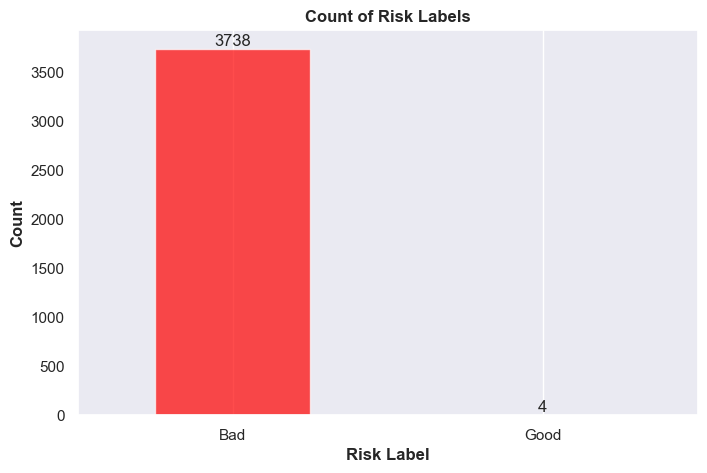

In [13]:
rfms_scoring['Risk'] = rfms_scoring['Cluster'].map(lambda x: ['Bad', 'Good'][x])

# count the values for this risk group
counts = rfms_scoring['Risk'].value_counts()

plot_bar_chart_with_values(counts=counts)

In [14]:
counts

Risk
Bad     3738
Good       4
Name: count, dtype: int64

This boundary as you can see is really harsh, it basically labels 99% of the users as having bad risk score. This obviously reduces the risk but it won't be able to help the bank operate with a profit since it pushes away a lot of users/customers

- Now let me try using just the RFMS_Score for the kmean clustering

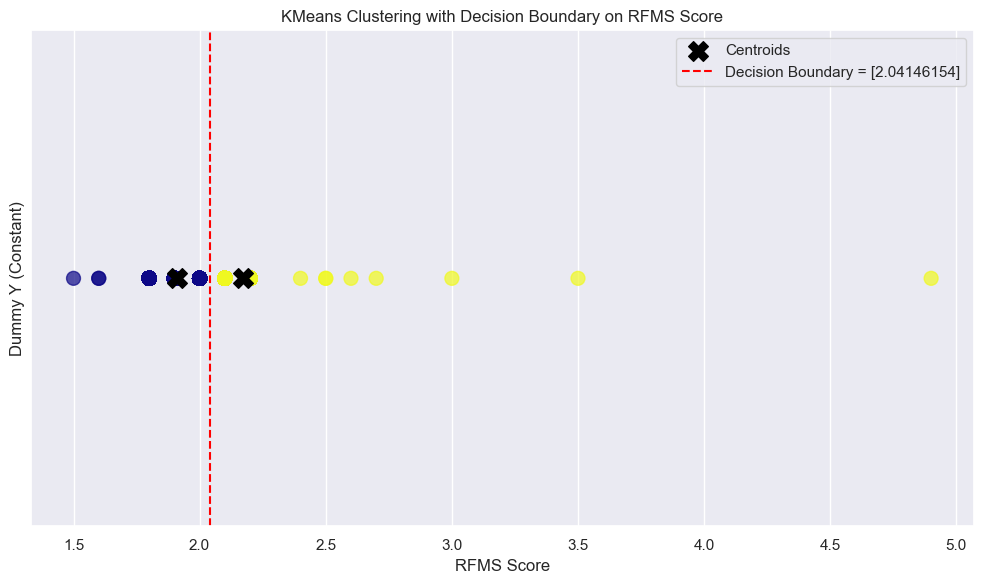

In [15]:
# Assuming rfms_scoring is your DataFrame and RFMS_Score is calculated
data_for_kmeans = rfms_scoring[['RFMS_Score']].values

# Create KMeans object with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)

# Fit the model and predict the clusters
rfms_scoring['Cluster'] = kmeans.fit_predict(data_for_kmeans)

# Create a new DataFrame for plotting
# Use RFMS_Score for the x-axis and a constant for the y-axis
plot_data = pd.DataFrame({
    'RFMS_Score': rfms_scoring['RFMS_Score'],
    'Dummy_Y': np.zeros(len(rfms_scoring))  # Constant value for y-axis
})

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot
sc = ax.scatter(
    plot_data['RFMS_Score'],    # x-axis
    plot_data['Dummy_Y'],       # y-axis (constant)
    c=rfms_scoring['Cluster'],  # Use the 'Cluster' column to determine colors
    cmap='plasma',              # Color map
    s=100,                      # Point size
    alpha=0.7                   # Transparency
)

# Add centroids to the plot
centroids = kmeans.cluster_centers_
ax.scatter(centroids, [0, 0], color='black', s=200, marker='X', label='Centroids')

# Draw a line for the decision boundary (you can choose the mean of centroids)
decision_boundary = (centroids[0] + centroids[1]) / 2
ax.axvline(x=decision_boundary, color='red', linestyle='--', label=f'Decision Boundary = {decision_boundary}')

# Set axis labels
ax.set_xlabel('RFMS Score')
ax.set_ylabel('Dummy Y (Constant)')
ax.set_yticks([])  # Hide y-axis ticks since it's constant

# Add a legend
plt.legend()
plt.title('KMeans Clustering with Decision Boundary on RFMS Score')
plt.tight_layout()

# Show the plot
plt.show()

- Plot the amount of users for the classification

In [16]:
rfms_scoring['Risk'] = rfms_scoring['Cluster'].map(lambda x: ['Bad', 'Good'][x])

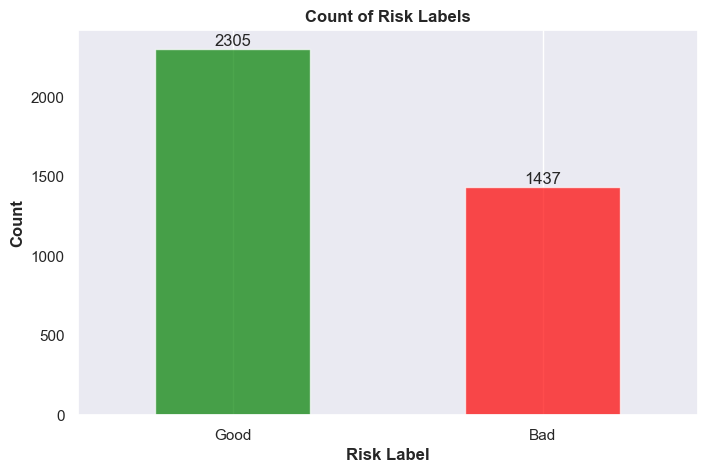

In [17]:
# count the values for this risk group
counts = rfms_scoring['Risk'].value_counts()

plot_bar_chart_with_values(counts=counts)

In [18]:
counts

Risk
Good    2305
Bad     1437
Name: count, dtype: int64

This is a way better but I think the boundary is more forgiving given the objective of this task, which is to create a credit scoring system that has a reasonable amount of risk. It is now set at 2.04 Risk Score value, this is less than half of the max value which I believe underestimates the riskiness of users given the business objective.

Now one method that is left is to create this boundary using quantiles instead

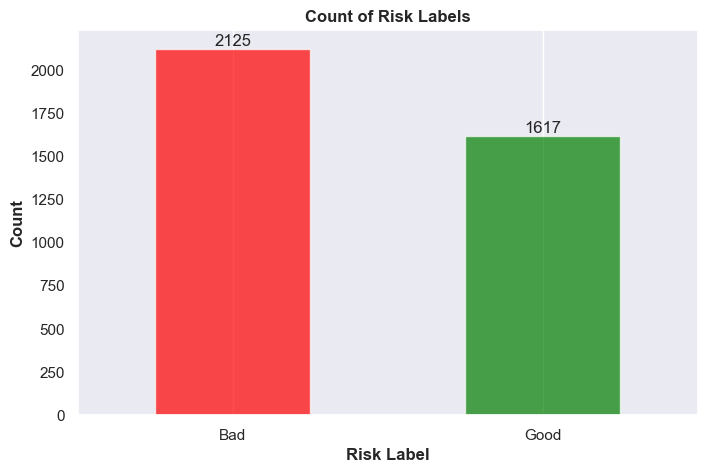

In [19]:
values = pd.qcut(x=rfms_scoring['RFMS_Score'], q=[0, 0.55, 1], labels=['Bad', 'Good'])

counts = values.value_counts()
plot_bar_chart_with_values(counts=counts)

In [20]:
boundary = rfms_scoring['RFMS_Score'].quantile(q=0.55)
print(f"Risk Score boundary value: {boundary}")

Risk Score boundary value: 2.1


From the results of the labeling of user risks, I believe what I have at hand now is better. It isn't overly harsh nor is it overly forgiving for usres. I think using the 55th quantile is the best option. The boundary that resulted was about 2.1 risk score, about 0.06 higher than the one selected by kmeans. 

- Use the Credit Scorer class to do the above steps

In [21]:
scored_rfms = credit_engine.score_rfms(rfms_data=rfms_data)
labeled_rfms, decision_boundary = credit_engine.label_rfms_score(data=scored_rfms, score_column='RFMS_Score')
print(f"The boundary chosen is: {decision_boundary} RFMS_Score")

The boundary chosen is: 2.1 RFMS_Score
